In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
# Load Data

column_file = 'spambase.names'
data_file = 'spambase.data'

In [3]:
# Column names

columns = [
    # Word frequency features
    'word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our',
    'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail',
    'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses',
    'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit',
    'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp',
    'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs',
    'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
    'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct',
    'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re',
    'word_freq_edu', 'word_freq_table', 'word_freq_conference',
    
    # Character frequency features
    'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 'char_freq_$', 'char_freq_#',

    # Capital run length features
    'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total',
    
    # Label
    'label'
]

df = pd.read_csv(data_file, header=None, names=columns)

# Separate features and label
X = df.drop('label', axis=1)
y = df['label']

In [4]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Full dataset evaluation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

print("=== Evaluation on Full Dataset ===")
results = []
for name, model in models.items():
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    results.append((name, precision, recall, f1))

full_results_df = pd.DataFrame(results, columns=["Model", "Precision", "Recall", "F1 Score"])
print(full_results_df)

=== Evaluation on Full Dataset ===
                 Model  Precision    Recall  F1 Score
0  Logistic Regression   0.929764  0.890789  0.909859
1        Decision Tree   1.000000  0.998345  0.999172
2        Random Forest   0.998897  0.999448  0.999173


In [10]:
# 5-Fold Cross Validation
print("\n=== 5-Fold Cross Validation ===")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for name, model in models.items():
    scores = cross_validate(model, X_scaled, y, cv=cv,
                            scoring=['precision', 'recall', 'f1'],
                            return_train_score=False)
    precision_mean = np.mean(scores['test_precision'])
    recall_mean = np.mean(scores['test_recall'])
    f1_mean = np.mean(scores['test_f1'])
    cv_results.append((name, precision_mean, recall_mean, f1_mean))

cv_results_df = pd.DataFrame(cv_results, columns=["Model", "CV Precision", "CV Recall", "CV F1 Score"])
print(cv_results_df)



=== 5-Fold Cross Validation ===
                 Model  CV Precision  CV Recall  CV F1 Score
0  Logistic Regression      0.920916   0.886355     0.903028
1        Decision Tree      0.876597   0.890220     0.883164
2        Random Forest      0.950673   0.924414     0.937268


In [7]:
#Feature Importance from Best Model
best_model_name = cv_results_df.sort_values("CV F1 Score", ascending=False).iloc[0]['Model']
print(f"\nBest model based on CV F1 Score: {best_model_name}")

if best_model_name == "Random Forest":
    best_model = RandomForestClassifier(n_estimators=100)
    best_model.fit(X, y)
elif best_model_name == "Decision Tree":
    best_model = DecisionTreeClassifier()
    best_model.fit(X, y)
else:
    best_model = LogisticRegression(max_iter=1000)
    best_model.fit(X_scaled, y)



Best model based on CV F1 Score: Random Forest


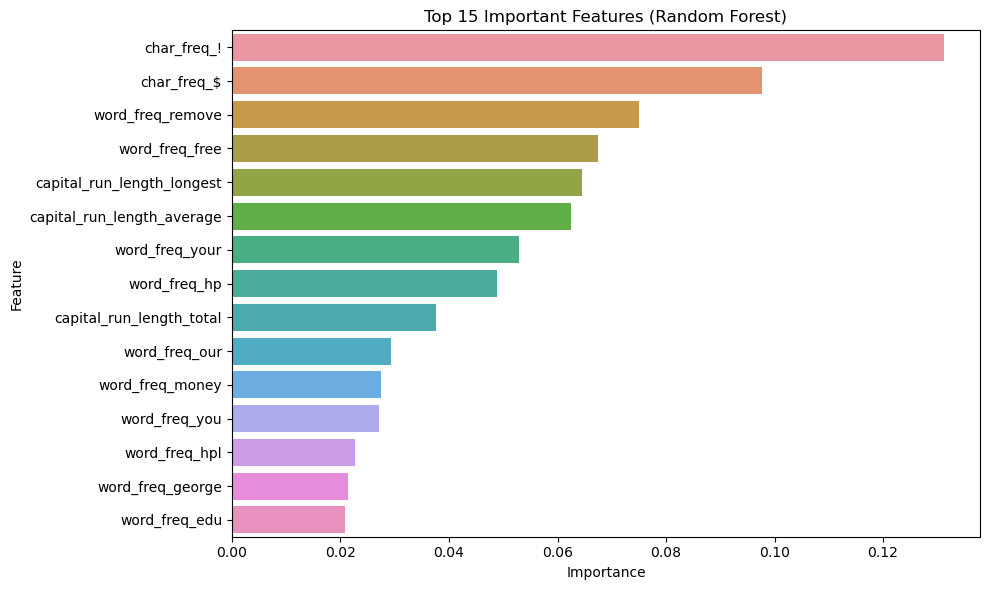

In [24]:
# Extract and plot feature importances
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    features = X.columns
elif hasattr(best_model, 'coef_'):
    importances = np.abs(best_model.coef_[0])
    features = X.columns
else:
    importances = None

if importances is not None:
    feature_importance_df = pd.DataFrame({
        "Feature": features,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False).head(15)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
    plt.title(f"Top 15 Important Features ({best_model_name})")
    plt.tight_layout()
    plt.show()
else:
    print("Feature importance not available for this model.")